# Airbnb data analysis

## Introduction

The massive adoption of the Airbnb service in the world has changed the way people travel, and how the hotel industry works. There is a lot of controversy about this service. The City of Berlin chose to ban the service entirely, and later made exception allowing people having only a secondary residency there to rent it, but for a limited amount of time per year. In the case of Amsterdam, a deal has been made directly with the company to limit the number of days that any given apartment can be rented.

But what are the concerns here? Is it the hotel industry that suffers? Are the denizens of those cities directly threatened by rises in housing prices and speculation? In this work, we want to explore the data offered by the website http://insideairbnb.com/. We will try not to take any conclusion beforehand and simply try to find correlation between the usage of the housing service and different indicators published by the national statistics service themselves.

We chose to do those analysis on the two aforementioned cities, Berlin and Amsterdam, since they are both major touristic capitals in Europe, and quite close to each other. Comparing the two might help us have more insight on the effect of the business. The two cities have put in place major regulation on the service in 2016. We will therefore compare analyse the evolution of those factor between 2015 and 2017.

## Inside Airbnb data imports and helper functions definitions

In [1]:
%matplotlib inline

import os
import folium
import numpy  as np
import pandas as pd
import geopandas as gpd

DATASETS_ROOT="datasets"
INSIDE="Inside-Airbnb"
NATIONAL="National"
CITIES=["Amsterdam", "Berlin"]

In [2]:
def load_amsterdam_geo():
    amsterdam_topo = os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson")
    m = folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
    )

    folium.GeoJson(
        amsterdam_topo,
        name='geojson'
    ).add_to(m)
    
    return m

In [3]:
def load_berlin_geo():
    berlin_topo = os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson")
    m = folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    )

    folium.GeoJson(
        open(berlin_topo,  'r', encoding='utf-8').read(),
        name='geojson'
    ).add_to(m)
    
    return m

In [4]:
def load_listing(city, year, full = False):
    filename = "listings.csv" if not full else "listings 2.csv"
    file = os.path.join(DATASETS_ROOT, city, INSIDE, year, filename)
    return pd.read_csv(file)

In [5]:
def load_calendar_data(city, year):
    file = os.path.join(DATASETS_ROOT, city, INSIDE, year, "calendar.csv")
    return pd.read_csv(file)

def load_listing_data(city, year):
    pass

In [6]:
def density_neighbourhood():
    pass

def availability_neighbourhood():
    pass

The following method creates a choropleth for a city given the starting map, a path to the GeoJSON file as well as a dataframe containing at least two columns:

- counts: the number of AirBnB
- neigbourhood: The name of the neigbourhood

In [7]:
def neighbourhood_map(start_map, path, stats):
    from shapely.geometry import Polygon, mapping
    
    geo_df = gpd.read_file(path)

    text = []
    list_geo = []
    gj = []

    for i in range(stats.index.size):
        current = stats.loc[i]
        selected = geo_df[geo_df['neighbourhood'] == current.neighbourhood]

        mp = mapping(selected.geometry)
        list_geo.append(selected)
        text.append(current.neighbourhood +  '<br>' + 'Number of available AirBnB: ' + str(current.counts))
        gj.append(folium.GeoJson(mp, style_function=lambda feature: {
            'opacity' : 0.7 , 'fillColor': '#FFFFFFFF', 'color' : 'blue'
        }))

    start_map.choropleth(
        geo_data=open(path,  'r', encoding='utf-8').read(),
        name='choropleth',
        data=stats,
        columns=['neighbourhood', "counts"],
        fill_color='PuBuGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        key_on='properties.neighbourhood',
        legend_name='Number of AirBnB available',
        threshold_scale=np.linspace(0, stats.counts.max(), 6).tolist()
    )

    for i in range(geo_df.index.size):
        if i < len(text):
            gj[i].add_child(folium.Popup(text[i]))
            gj[i].add_to(start_map)
    return start_map

In [8]:
amsterdam_calendar_data_2015 = load_calendar_data("Amsterdam", "2015")
amsterdam_calendar_data_2017 = load_calendar_data("Amsterdam", "2017")

amsterdam_listing_2015 = load_listing("Amsterdam", "2015")
amsterdam_listing_2017 = load_listing("Amsterdam", "2017")

amsterdam_listing_2015_full = load_listing("Amsterdam", "2015", True)
amsterdam_listing_2017_full = load_listing("Amsterdam", "2017", True)

In [9]:
amsterdam_map = load_amsterdam_geo()

In [10]:
berlin_calendar_data_2016 = load_calendar_data("Berlin", "2016")
berlin_calendar_data_2017 = load_calendar_data("Berlin", "2017")

berlin_listing_2016 = load_listing("Berlin", "2016")
berlin_listing_2017 = load_listing("Berlin", "2017")

berlin_listing_2016_full = load_listing("Berlin", "2016", True)
berlin_listing_2017_full = load_listing("Berlin", "2017", True)

In [11]:
berlin_map = load_berlin_geo()

## Exploring data from the Inside Airbnb dataset

### Berlin - Inside Airbnb

Here we display the density of usage of Airbnb across the different neighbourhood of the city.
The first step is to match neighbourhood from the GeoJSON and the listing.

Let's extract the neighbourhoods from the listing:

In [12]:
berlin_listing_ng_names = berlin_listing_2016.neighbourhood.unique()
berlin_listing_2016_neig_stats = berlin_listing_2016.groupby("neighbourhood").size().reset_index(name="counts")

We want to be able to see the number of AirBnB inside each neighbourhood, so we load the GeoJSON as a GeoPanda and then map it with the dataframe created above

In [13]:
neighbourhood_map(folium.Map(
        location=[52.52437, 13.41053],
        zoom_start=11
    ), os.path.join(DATASETS_ROOT, "Berlin", "neighbourhoods.geojson"), berlin_listing_2016_neig_stats)

From this map, we can conclude that the neighboorhoods in the center are more attractive on AirBnB than the one farthest from the center. It's probably because tourists prefers to be in the center of the town more than being far from the touristic places.

We explore a bit of temporal data to see how the service is used during one full year. We look at what has changer between 2016 and 2017.

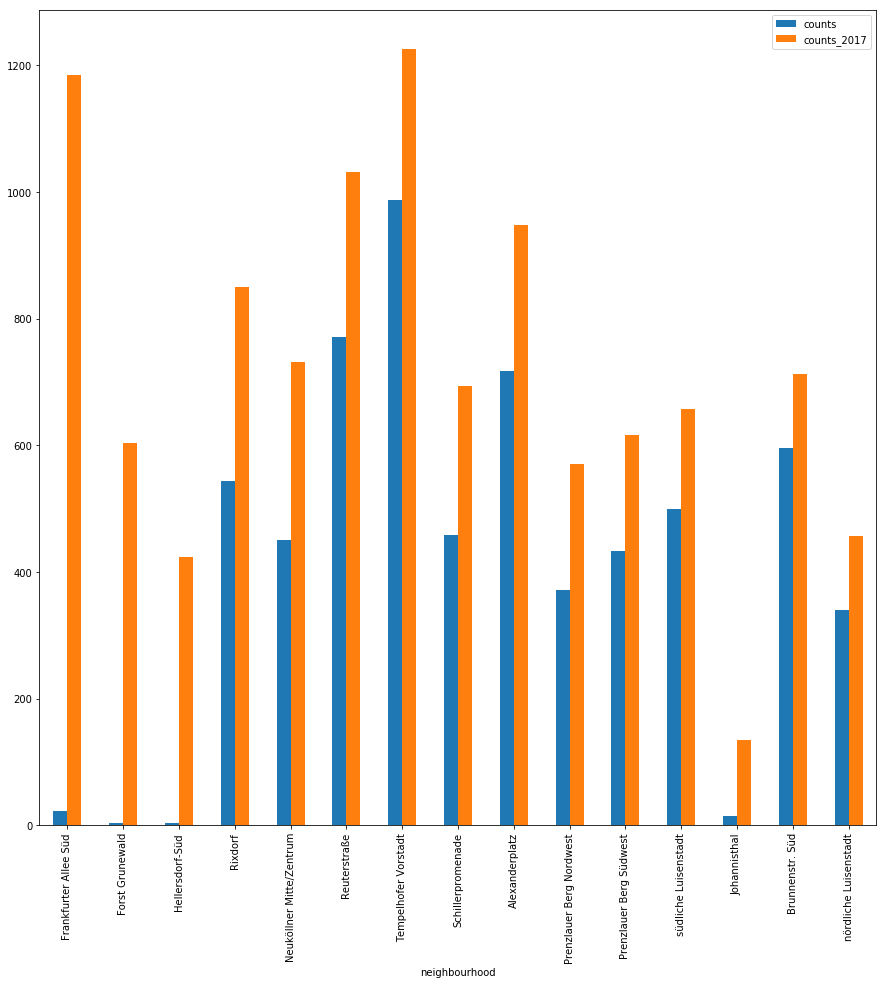

In [14]:
berlin_listing_2017_neig_stats = berlin_listing_2017.groupby("neighbourhood").size().reset_index(name="counts")
berlin_ng_stat_merge = berlin_listing_2016_neig_stats.join(berlin_listing_2017_neig_stats, rsuffix="_2017")
berlin_ng_stat_merge['diff'] = berlin_ng_stat_merge['counts_2017'] - berlin_ng_stat_merge['counts']
berlin_ng_stat_merge = berlin_ng_stat_merge.sort_values(by=['diff'], ascending=False)
berlin_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['counts', 'counts_2017'], kind='bar', figsize=(15, 15))

But we can also see that many neighbourhoods have also lost in popularity

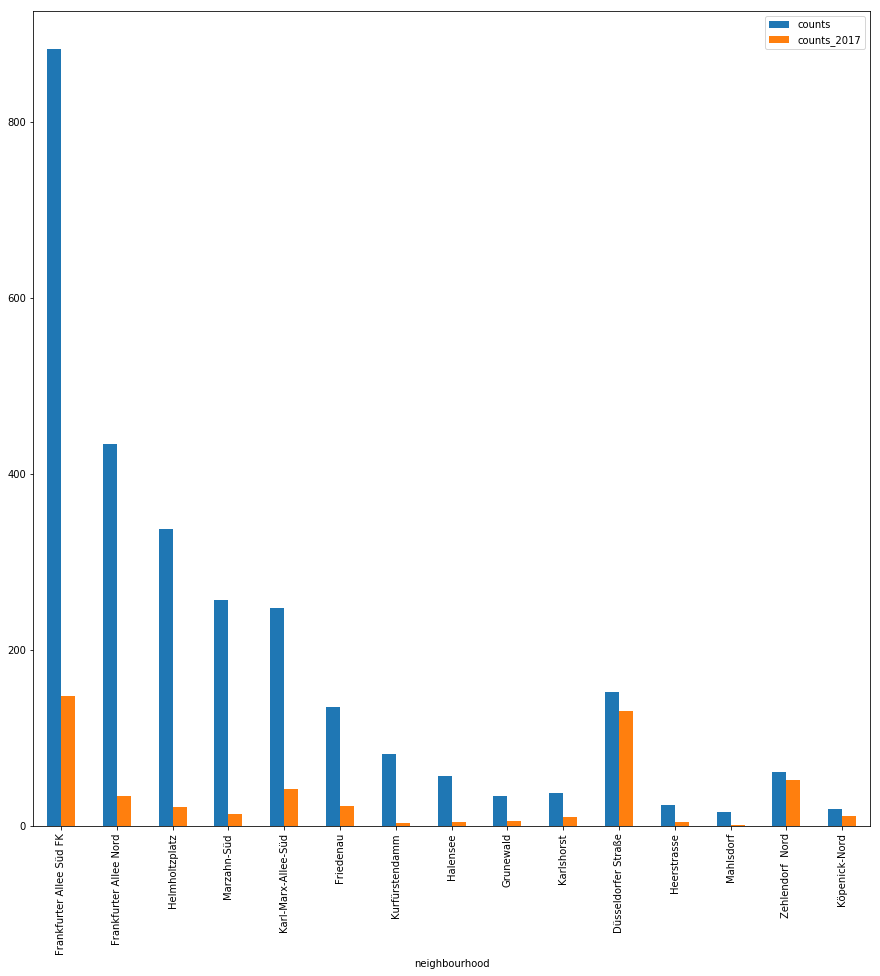

In [15]:
berlin_ng_stat_merge = berlin_ng_stat_merge.sort_values(by=['diff'], ascending=True)
berlin_ng_stat_merge.head(n=15).plot(x='neighbourhood', y = ['counts', 'counts_2017'], kind='bar', figsize=(15, 15))

###  Amsterdam - Inside Airbnb

Here we display the density of usage of Airbnb across the different neighbourhood of the city.

In [16]:
amsterdam_listing_ng_names = amsterdam_listing_2015.neighbourhood.unique()
amsterdam_listing_2015_neig_stats = amsterdam_listing_2015.groupby("neighbourhood").size().reset_index(name="counts")

In [17]:
neighbourhood_map(folium.Map(
        location=[52.370216, 4.895168],
        zoom_start=12
    ), os.path.join(DATASETS_ROOT, "Amsterdam", "neighbourhoods.geojson"), amsterdam_listing_2015_neig_stats)

We explore a bit of temporal data to see how the service is used during one full year. We look at what has changer between 2015 and 2017.


## National data imports

In [18]:
def load_national_data(city, file_name):
    file = os.path.join(DATASETS_ROOT, city, NATIONAL, file_name)
    return pd.read_csv(file)

In [19]:
am_2013_to_2017_number_of_housing = load_national_data("Amsterdam", "2013_to_2017_number_of_housing.csv")
am_2015_2016_total_sales_prices = load_national_data("Amsterdam", "2015_2016_total_sales_prices.csv")
am_2017_number_of_room_per_dwelling = load_national_data("Amsterdam", "2017_number_of_room_per_dwelling.csv")
am_2017_satisfaction_with_living_environment = load_national_data("Amsterdam", "2017_satisfaction_with_living_environment.csv")

## Exploring data from national sources

### Berlin - National Data

Analysis of the price of housing over time.

Size of apartments in different neighbourhoods.


Rental price categories for private housing.


Satisfaction with house and living environment per district.


### Amsterdam - National Data

Analysis of the price of housing over time.

Size of apartments in different neighbourhoods.


Rental price categories for private housing.


Satisfaction with house and living environment per district.


## Combining and comparing the results

Finding correlation between national and Inside Airbnb data

## Conclusion

One interesting challenge with this project was to gather data from website in other languages. German was still okay for us - even if the vocabulary was quite technical sometimes. Gathering data from a dutch website was more challenging, but automatic translation tools helped us.

In this work, we learned that […]